In [81]:
import sys
import datetime
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

sys.path.append('..')

from definitions import INPUT_DATA_DIR, PARSED_DATA_DIR, SUB_DIR, FULL_DATA_DIR

%reload_ext autoreload
%autoreload 2

In [82]:
version = {
    'lightgbm': lgb.__version__,
    'pandas': pd.__version__,
    'numpy': np.__version__,
    'scikit-learn': sk.__version__ 
}
print(version)

{'lightgbm': '3.3.2', 'pandas': '1.4.3', 'numpy': '1.23.1', 'scikit-learn': '1.1.1'}


# 1. Загрузка данных

In [83]:
from app.transformers.base import Compose
from app.transformers.preprocess import (
    LoaderMergePreprocess, 
    CategoryFromTextPreprocess, 
    AuthorsPreprocess,
    TagsPreprocess,
    FeaturePreprocess,
    SaverPreprocess,
    NatashaTransformer
)

In [84]:
Preprocessor = Compose(
    transforms=[
        LoaderMergePreprocess(name='loading'),
        CategoryFromTextPreprocess(name='category from text'),
        AuthorsPreprocess(name='authors preprocess'),
        TagsPreprocess(name='tags preprocess'),
        FeaturePreprocess(name='feature selector'),
        NatashaTransformer(name='natasha name entity'),
        SaverPreprocess(name='saving files')
    ]
)

In [ ]:
train = Preprocessor(data=pd.DataFrame(), mode='train')
test = Preprocessor(data=pd.DataFrame(), mode='test')

In [85]:
train = pd.read_json(FULL_DATA_DIR / 'full_train.json')
test = pd.read_json(FULL_DATA_DIR / 'full_test.json')

## 2. Предсказание для существующих

In [86]:
from app.prediction.utils import predict_for_exist
from app.constants import FeaturesConstants

In [87]:
exist_prediction = predict_for_exist(train, test)

In [88]:
train_and_tests_ctr_ = list(set(train['page_id']) & set(test['page_id']))

In [89]:
train_data = (
    train[~(train['page_id'].isin(train_and_tests_ctr_))]
    .drop_duplicates(FeaturesConstants.target + ['document_id', 'page_id', 'ctr'])
)
print(train_data.shape)
train_data = train_data[train_data['full_reads_percent'] <= 100]
train_data = train_data[train_data['views'] <= 1000000].copy()

y_data = train_data[FeaturesConstants.target].copy()

test_data = test[~(test['page_id'].isin(train_and_tests_ctr_))].copy()

(6921, 30)


In [90]:
np.quantile(train_data['full_reads_percent'], 1)

75.729

In [91]:
np.quantile(np.sort(train_data['views']), 0.05)

1733.1000000000001

In [92]:
train_data.shape, test_data.shape, exist_prediction.shape

((6918, 30), (2967, 27), (33, 4))

## 3. Feature Generation

## 3.1 Identifier

- `page_id`: `624ac09c9a7947db3d80c98e`

## 3.2 Date

- `publish_date`: `2022-04-04 10:29:44` + `timedelta(hours=3)`

## 3.3 Title

- `title` - title новости от организаторов, (**текст**)
- `title_parsed` - спарсенный title новости, (**текст**)
- `optional[title_parsed_from_yandex]` - заголовок статьи в `yandex`, (**текст**)
- `title_preprocessed` - удалены `category`

## 3.4 Category

- `category` - категория новости, **hash**
- `category_parsed` - спарсенная категория новости, **текст**
- `category_from_title` - категория, выделенная из текста, **Optional[текст]**

## 3.5 Ctr

- `ctr` - показатель кликабельности, **Optional[float64]**

## 3.6 Tags

- `tags` - таги, закодированные от организаторов, **Optional[hash]**
- `tags_parsed` - спарсенные тэги, **Optional[текст]**

## 3.7 Auhtors

- `authors` - авторы новости от организаторов, **Optional[hash]**
- `authors_parsed` - авторы новости **Optional[текст]**

## 3.8 Text

- `news_text_parsed` - текст новости, полный, **текст** 
- `news_text_overview_parsed` - некоторая выжимка новости, **текст**
- `news_amount_of_paragraphs_parsed` - количество параграфов в тексте, **int64**
- `news_amount_of_inline_items_parsed` - количество ссылок на другие новости в тексте новости, **int64**
- `news_inline_titles_parsed` - заголовки на другие статьи в тексте новости, **Optional[текст]**
- `news_has_image_parsed` - есть ли в новости картинка, **int64**
- `news_image_title_parsed` - подпись к изображению, если есть, **Optional[текст]**

## 3.9. Features Selector Transformer

In [93]:
from app.transformers.feature_generation import (
    DatetimeTransformer,
    TitleTransformer,
    CategoryTransformer,
    CTRTransformer,
    TagsTransformer,
    AuthorsTransformer,
    TextTransformer,
    NatashaTextTransformer,
    FeatureSelector,
    
    AuthorsTFIDFFitTransformer,
    TagsTFIDFFitTransformer,
)


# 4. Model Fitting

In [94]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(FeaturesConstants.MODEL_NAME)

In [ ]:
embeddings = model.encode(train_data['title_preprocessed'].values)

In [95]:
def plotImp(
    model,
    X, 
    num=10, 
    fig_size = (40, 20)
):
    feature_imp = pd.DataFrame(
        {'Value': model.feature_importances_,
         'Feature': X.columns}
    )
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    sns.barplot(
        x="Value", 
        y="Feature", 
        data=feature_imp.sort_values(by="Value", ascending=False)[0:num],
        ax=ax
    )
    plt.show()

In [96]:
kfold = KFold(n_splits=3, shuffle=True, random_state=239)

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
import lightgbm as lgb
import optuna
# import optuna.integration.lightgbm as lgb

from sklearn.model_selection import RepeatedKFold


In [98]:
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer


C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[]


C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[]


C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[]
views:  0.6935221437748736


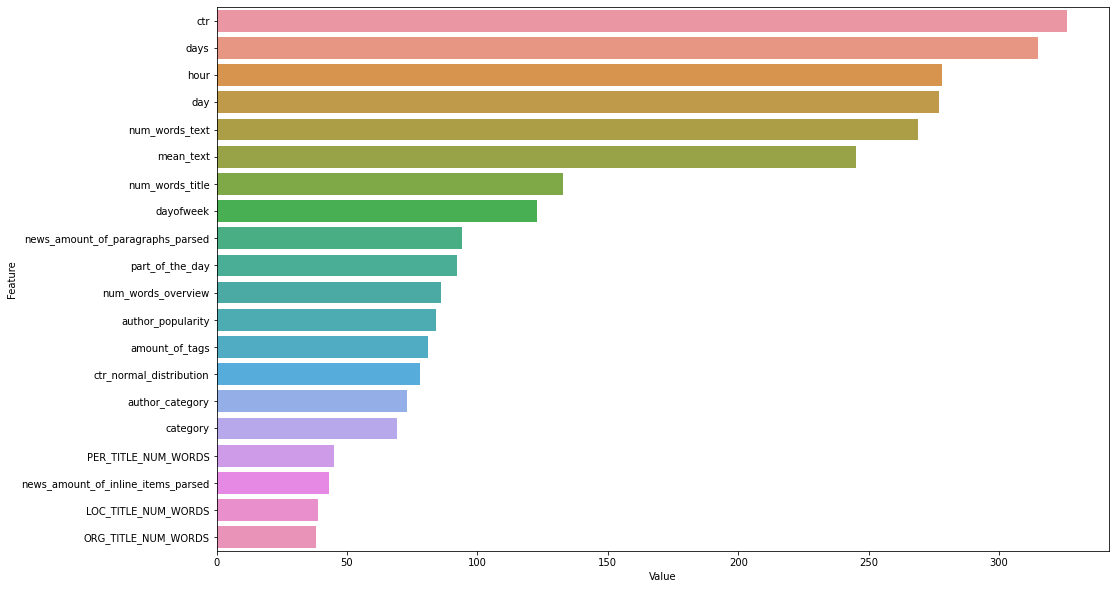

train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer


C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[]


C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[]


C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[]
depth:  0.8338933734091092


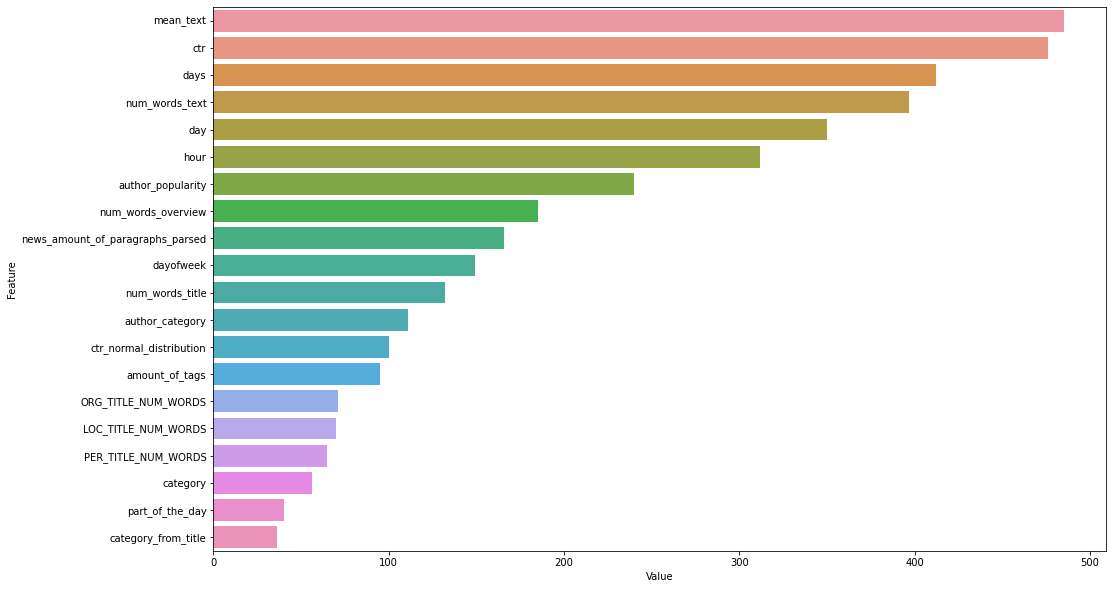

train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
train: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer
test: transformer


C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[]


C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[]


C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\shiro\Desktop\DATABASE\competitions\summer_2022\rbk\.venv\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[]
full_reads_percent:  0.5475992101166663


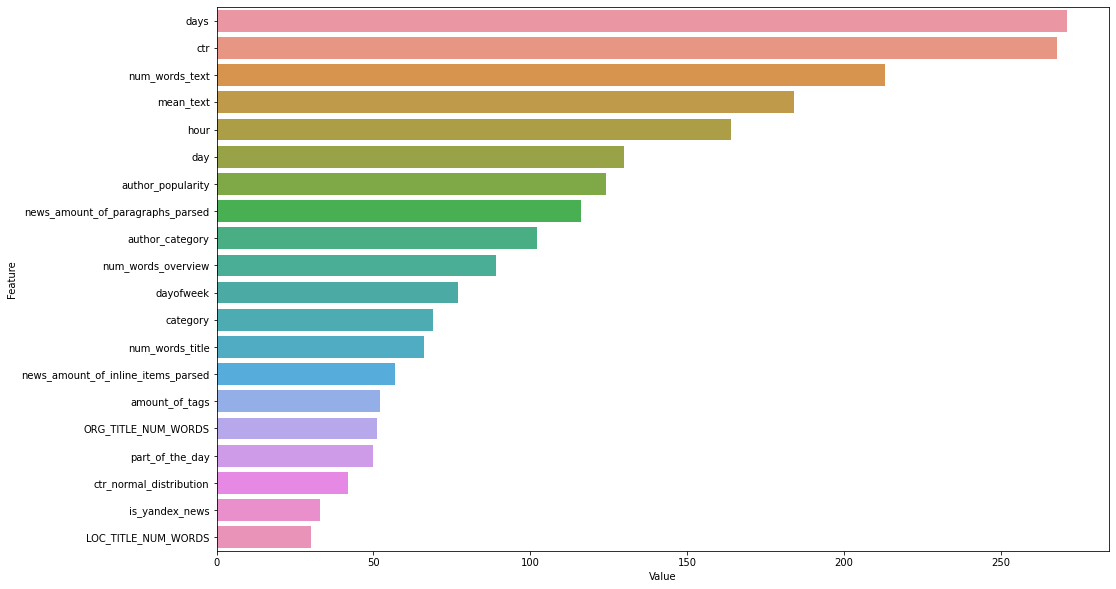

Final score: 0.6918566325676822, median: 0.6915622955058924


In [99]:
result_dict = {
    'views': {'r2': [], 'prediction': []},
    'full_reads_percent': {'r2': [], 'prediction': []},
    'depth': {'r2': [], 'prediction': []}
}
for target_variable in FeaturesConstants.target:
#     if target_variable in ['views', 'depth']:
#         continue
    FeatureGenerator = Compose(
        transforms=[
            DatetimeTransformer(full='use' if target_variable == 'full_reads_percent' else None),
            TitleTransformer(),
            CTRTransformer(eps=0.1 if target_variable == 'views' else 0.5),
            TagsTransformer(),
            AuthorsTransformer(),
            TextTransformer(),
            NatashaTextTransformer(),
            CategoryTransformer(),
            FeatureSelector()
        ]
    )
    train_features = FeatureGenerator(data=train_data, mode='train')
    test_features = FeatureGenerator(data=test_data, mode='test')
    cec = AuthorsTFIDFFitTransformer()
    cec.fit(train_data)
    
    train_features['author_popularity'] = cec.transform(train_data)
    test_features['author_popularity'] = cec.transform(test_data)
    
#     import copy
#     train_ebmeddings = copy.deepcopy(embeddings)
#     idx = train_ebmeddings.sum(axis=1) != 0
#     train_ebmeddings[idx] = train_ebmeddings[idx] / np.linalg.norm(train_ebmeddings[idx], ord=2,axis=1).reshape((-1,1))
#     train_features = pd.concat((train_features, pd.DataFrame(train_ebmeddings, index=train_features.index)), axis=1)
    
#     print(train_features.shape, test_features.shape)


    

#     train_ddd = cec.transform(train_data)
#     test_ddd = cec.transform(test_data)
#     print(train_ddd.shape, test_ddd.shape)
#     train_features = pd.concat([train_features, train_ddd], axis=1)
#     test_features = pd.concat([test_features, test_ddd], axis=1)
#     print(train_features.shape, test_features.shape)
#     c = TagsTFIDFFitTransformer()
#     c.fit(train_data)
#     train_features['tag_popularity'] = c.transform(train_data)
#     test_features['tag_popularity'] = c.transform(test_data)
    for train_index, val_index in kfold.split(train_features):
        X_train, X_valid = (
            train_features.reset_index(drop=True).iloc[train_index, :], 
            train_features.reset_index(drop=True).iloc[val_index, :]
        )
        y_train, y_valid = (
            y_data[target_variable].reset_index(drop=True).iloc[train_index], 
            y_data[target_variable].reset_index(drop=True).iloc[val_index]
        )
        if target_variable == 'views':
            y_train = np.log(y_train)
            y_valid = np.log(y_valid)
        elif target_variable == 'depth':
            y_train = np.log(np.log(y_train))
            y_valid = np.log(np.log(y_valid))
        else:
            y_train = np.log(y_train)
            y_valid = np.log(y_valid)
            
        if target_variable == 'me':
            pass
        else:
            dtrain = lgb.Dataset(X_train, label=y_train)
            dvalid = lgb.Dataset(X_valid, label=y_valid)            
            
            lgbm_regressor = lgb.LGBMRegressor(
                objective='rmse',
                random_state=33,
                early_stopping_round=3000, 
                n_estimators=500,
                colsample_bytree=0.95,
                learning_rate=0.09,
                max_depth=-1,
                verbose=-1
            )
            lgbm_regressor.fit(X_train, 
                     y_train, 
                     eval_set=[(X_valid, y_valid)], 
                     eval_metric='rmse', verbose=-1)
        y_pred = lgbm_regressor.predict(X_valid)
        r2 = r2_score(y_valid, y_pred)
        result_dict[target_variable]['r2'].append(r2)
        
        pro = lgbm_regressor.predict(test_features)
        if target_variable == 'views':
            pro = np.exp(pro)
        elif target_variable == 'depth':
            pro = np.exp(np.exp(pro))
        else:
            pro = np.exp(pro)
        print(pro[pro < 0])
        result_dict[target_variable]['prediction'].append(pro)
    print(f'{target_variable}: ', np.mean(result_dict[target_variable]['r2']))
    plotImp(lgbm_regressor, train_features, num=20, fig_size=(16, 10))

full_score = (
    np.mean(result_dict['views']['r2']) * 0.4 + 
    np.mean(result_dict['full_reads_percent']['r2']) * 0.3 + 
    np.mean(result_dict['depth']['r2']) * 0.3
)
full_score_2 = (
    np.median(result_dict['views']['r2']) * 0.4 + 
    np.median(result_dict['full_reads_percent']['r2']) * 0.3 + 
    np.median(result_dict['depth']['r2']) * 0.3
)
print(f'Final score: {full_score}, median: {full_score_2}')

# Sub4 - best

In [100]:
sub = pd.DataFrame(
    {
        'document_id': test_data['document_id'].values,
        'views': pd.DataFrame(result_dict['views']['prediction']).T.mean(axis=1),
        'depth': pd.DataFrame(result_dict['depth']['prediction']).T.mean(axis=1),
        'full_reads_percent': pd.DataFrame(result_dict['full_reads_percent']['prediction']).T.mean(axis=1),
    },
)
sub.index = test_data.index

In [101]:
sub_full = pd.concat((sub, exist_prediction)).sort_index()

In [102]:
ss = pd.read_csv('../sub/sample_solution.csv')

In [103]:
sub_full_2 = pd.DataFrame(ss['document_id'])

In [76]:
views = []
full_reads_percent = []
depth = []
for j, i in sub_full_2.iterrows():
    dummy = sub_full[sub_full['document_id'] == i['document_id']]
    views.append(dummy['views'].values[0])
    full_reads_percent.append(dummy['full_reads_percent'].values[0])
    depth.append(dummy['depth'].values[0])

In [77]:
sub_full_2['views'] = views
sub_full_2['full_reads_percent'] = full_reads_percent
sub_full_2['depth'] = depth

In [78]:
sub_full_2.to_csv(SUB_DIR / 'sub6_new_features.csv', index=False)

In [79]:
pd.read_csv(SUB_DIR / 'sub4_new_features.csv')

,document_id,views,full_reads_percent,depth
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,9457.623507,50.485956,1.217946
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,5601.495815,32.523831,1.054987
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,10928.994654,25.891150,1.062408
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,3667.071917,36.726318,1.062928
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,84951.030914,29.042000,1.117110
...,...,...,...,...
2995,623ba6bc9a79470214cb9418x4OZQ1IjTb27nPAgv5wAZg,25413.104453,33.897039,1.129245
2996,624fda1f9a79471a9bd102eetuRTrLPGSZyNbc9_YcBAeQ,38047.319707,33.003981,1.120423
2997,6257a6a99a79477eea75b86dtBr3UG9ORW-gOybkVKX6ww,7828.815530,41.844524,1.065188
2998,624866d59a7947421716ab46WsGDKyGjTJGRh14eR7UVvw,13244.841888,39.097132,1.172370


In [80]:
sub_full_2

,document_id,views,full_reads_percent,depth
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,8795.748221,50.067137,1.206407
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,5917.179816,31.890189,1.055747
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,11243.779252,25.815705,1.064187
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,4013.458581,36.992697,1.062790
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,102811.483830,27.300156,1.119380
...,...,...,...,...
2995,623ba6bc9a79470214cb9418x4OZQ1IjTb27nPAgv5wAZg,26918.677583,33.074175,1.130582
2996,624fda1f9a79471a9bd102eetuRTrLPGSZyNbc9_YcBAeQ,38413.603776,34.382631,1.123329
2997,6257a6a99a79477eea75b86dtBr3UG9ORW-gOybkVKX6ww,7728.913091,43.058665,1.065986
2998,624866d59a7947421716ab46WsGDKyGjTJGRh14eR7UVvw,12681.907559,40.111515,1.169854
